# BIGRU model one-hot applicatie inputs

In [70]:
from torch import optim
from data.dataloader import DatasetLoader, EventConnectionGraph
from torch.utils.data import DataLoader
import torch
from models.BiGRU import BiGRU
from models.MLP import MLP
from torch import nn
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

## 1. Event connection graph aanmaken

In [71]:
removeapps = ["Screen on (locked)",
              "Screen off (locked)",
              "Screen on (unlocked)",
              "Screen off",
              "Samsung Experience Service",
              "Package installer",
              "System UI",
              "Customisation Service",
              "Configuration update",
              "EmergencyManagerService",
              "DeviceKeystring",
              "Samsung Keyboard",
              "HwModuleTest",
              "Device shutdown",
              "Device boot"]
eventconnectiongraph = EventConnectionGraph("eventlog/phone_usage_cleaned.csv",
                                            nr_samples=2000, d=900, T=1200,
                                            removeapps=removeapps,
                                            nr_generated=100000)
datasampler = DataLoader(eventconnectiongraph, batch_size=16)

## 2. Embeddings pre-trainen op gegenereerde applicatie paren

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp = MLP(max_apps=eventconnectiongraph.nr_apps,
          src_dim=6)
mlp.to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

In [73]:
traincorrect = 0
sample = 0
epoch = []

for prev_app_index, next_app_index in datasampler:
    prev_app_index, next_app_index = prev_app_index.to(device=device), next_app_index.to(device=device)

    # Batch size increment
    sample+=prev_app_index.shape[0]

    # Make prediction
    outputs = mlp(prev_app_index)

    # Measure accuracy top-1
    arg_maxs = torch.argmax(outputs, dim=1)
    traincorrect += torch.sum(next_app_index==arg_maxs).item()

    # print(outputs[0].shape)
    # Calculate loss
    loss = criterion(outputs, next_app_index)

    # Cat Crossentropy met logsoftmax
    loss.backward()
    optimizer.step()

    # Reset gradient
    optimizer.zero_grad()

print(traincorrect/(sample))

0.12336


## 3. Dataset uitlezen en cleanen

In [74]:
""" batch size 16 voor pre-trainen """
dataset = DatasetLoader("eventlog/phone_usage_cleaned.csv", seq_length=10)
removeapps = ["Screen on (locked)",
              "Screen off (locked)",
              "Screen on (unlocked)",
              "Screen off",
              "Samsung Experience Service",
              "Package installer",
              "System UI",
              "Customisation Service",
              "Configuration update",
              "EmergencyManagerService",
              "DeviceKeystring",
              "Samsung Keyboard",
              "HwModuleTest",
              "Device shutdown",
              "Device boot"]
dataset.clean(removeapps)
train_dataloader = DataLoader(dataset, batch_size=16)

## 4. bigru model aanmaken en pre-trainen

In [75]:
""" stel device in als CUDA indien mogelijk """
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

""" Gebruikt BiGRu klasse
    Vervangt embedding matrix door eenheidsmatrix met vaste gewichten
    Trainingsnelheid zal iets lager zijn dan model met echte one-hot input
"""
bigru = BiGRU(max_apps=200,
              n_gru=64,
              src_dim=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bigru.parameters(), lr=0.001)

main_diagonal = torch.ones(size=[200])
bigru.to(device=device)
# embedding = torch.cat((mlp.src_embedding.weight, bigru.src_embedding.weight[eventconnectiongraph.nr_apps:]), dim=0)
embedding = mlp.src_embedding.weight
bigru.src_embedding.weight=torch.nn.Parameter(embedding)
bigru.src_embedding.weight.requires_grad = False

bigru.to(device=device)

BiGRU(
  (src_embedding): Embedding(200, 6)
  (bigru): GRU(6, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=200, bias=True)
)

In [76]:
epochs = 10
training_samples = 1600
testing_samples = 400

traincorrect = 0
valcorrect = 0

trainacchistory = []
trainlosshistory = []
valacchistory = []
vallosshistory = []
epoch = []

for j in range(epochs):

    sample = 0
    traincorrect = 0
    trainloss = 0
    valcorrect = 0
    valloss = 0

    for prev_apps_indices, curr_app_index in train_dataloader:
        prev_apps_indices, curr_app_index = prev_apps_indices.to(device), curr_app_index.to(device)

        h = bigru.init_hidden(batch_size=16).to(device)

        # Niet meer dan 1600 eerste samples gebruiken
        if sample < training_samples:
            # Batch size increment
            sample+=prev_apps_indices.shape[0]

            # Reset gradient
            optimizer.zero_grad()

            # Output continue logit vector
            outputs, h = bigru(prev_apps_indices, h)

            # Cat Crossentropy met logsoftmax
            loss = criterion(outputs, curr_app_index)

            trainloss += loss.item()*prev_apps_indices.shape[0]

            # Optimize weights
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            traincorrect += (predicted == curr_app_index).sum().item()

        elif training_samples <= sample < training_samples + testing_samples:
            # Batch size increment
            sample+=prev_apps_indices.shape[0]

            # Reset gradient
            optimizer.zero_grad()

            # Output continue logit vector
            outputs, h = bigru(prev_apps_indices, h)

            # Cat Crossentropy met logsoftmax
            loss = criterion(outputs, curr_app_index)

            valloss += loss.item()*prev_apps_indices.shape[0]

            _, predicted = torch.max(outputs.data, 1)
            valcorrect += (predicted == curr_app_index).sum().item()

        else:
            break

    trainacchistory.append(traincorrect/(training_samples))
    trainlosshistory.append(trainloss/(training_samples))
    valacchistory.append(valcorrect/(testing_samples))
    vallosshistory.append(valloss/(testing_samples))
    epoch.append(j)


    # print("epoch nr: " +  str(j))
    # print(traincorrect/(training_samples))
    # print(valcorrect/(testing_samples))
    # print()

## 5. Plot pre-training history

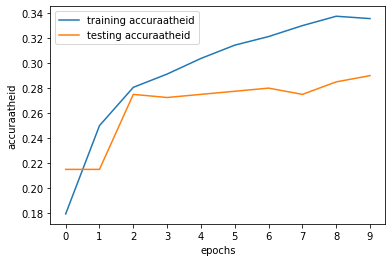

0.29
2.8578345251083372


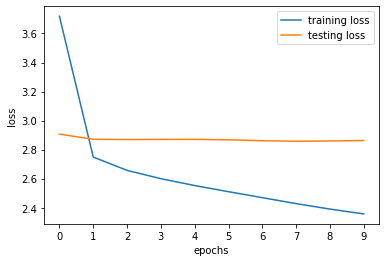

In [77]:
plt.plot(trainacchistory, label="training accuraatheid")
plt.plot(valacchistory, label="testing accuraatheid")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuraatheid')
plt.xticks(epoch)
plt.savefig(fname="outputdata/bigruonehotpretrainacc.png")
plt.show()
print(max(valacchistory))

plt.plot(trainlosshistory, label="training loss")
plt.plot(vallosshistory, label="testing loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xticks(epoch)
plt.savefig(fname="outputdata/bigruonehotpretrainloss.png")
plt.show()
print(min(vallosshistory))

## 6. bigru model online learning

In [78]:
""" Dataloader mag nu niet langer batches produceren """
train_dataloader = DataLoader(dataset, batch_size=1)

In [79]:
bigru.src_embedding.weight.requires_grad = True
running_accuracy_list = []
sample = 0
h = bigru.init_hidden(batch_size=1).to(device)
n_emb = len(bigru.src_embedding.weight)
for prev_apps_indices, curr_app_index in tqdm(train_dataloader):
    prev_apps_indices, curr_app_index = prev_apps_indices.to(device), curr_app_index.to(device)

    # Online learning, 1 sample
    sample += 1

    if sample > training_samples + testing_samples - 9:

        # Check for new app token
        if curr_app_index.item() > (n_emb-1):

            # Get token of last opened app
            prev_app_token = prev_apps_indices[0,-1].item()

            # Get embedding for prev app token
            prev_app_embedding = bigru.src_embedding.weight[prev_app_token:prev_app_token+1]

            # Add it to embedding matrix
            newembedding = torch.cat((bigru.src_embedding.weight, prev_app_embedding),
                                     dim=0)
            bigru.src_embedding.weight = torch.nn.Parameter(newembedding)
            n_emb+=1

        # Make prediction
        outputs, h = bigru(prev_apps_indices, h)

        # Measure accuracy top-k
        _, predicted = torch.topk(outputs.data, 5)
        running_accuracy_list.append(curr_app_index in predicted)

        # Calculate loss
        loss = criterion(outputs, curr_app_index)

        # Cat Crossentropy met logsoftmax
        loss.backward()
        optimizer.step()

        # Reset gradient
        optimizer.zero_grad()

100%|██████████| 33627/33627 [01:14<00:00, 452.01it/s]


In [80]:
print(sum(running_accuracy_list)/len(running_accuracy_list))
print(len(running_accuracy_list))

0.7207927677329624
31636


## 7. Running accuracy opslaan

In [81]:
AccuracyComparison = pd.read_csv("outputdata/accuracycomparison.csv", index_col=False)
AccuracyComparison["embeddingsinheritancebigru"] = running_accuracy_list
AccuracyComparison.to_csv("outputdata/accuracycomparison.csv", index=False)
AccuracyComparison.head()


,MFU,MRU,onehotbigru,onehotlstm128,onehotlstm64,onehotgru64,onehotgru128,embeddingsbigru,embeddingsinheritancebigru
0,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False
